In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
from scipy.stats import chi2_contingency as chi2_contingency
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn import decomposition
import time
from sklearn.model_selection import KFold
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import prediction_error
from sklearn.model_selection import learning_curve

In [2]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import *
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from yellowbrick.regressor import ResidualsPlot

In [3]:
from sklearn.dummy import DummyRegressor

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression 
import warnings
warnings.filterwarnings("ignore")

In [5]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix

In [6]:
from sklearn.linear_model import LinearRegression 

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
pd.set_option('display.max_columns', 46);
pd.set_option('display.max_rows', 100)


In [9]:
df = pd.read_csv('projet_4_clean.csv',index_col=[0], )

In [10]:
df.shape

(1533, 31)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1533 entries, 252 to 2070
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   BuildingType                 1533 non-null   object 
 1   PrimaryPropertyType          1533 non-null   object 
 2   YearBuilt                    1533 non-null   int64  
 3   NumberofBuildings            1533 non-null   int64  
 4   NumberofFloors               1533 non-null   int64  
 5   PropertyGFATotal             1533 non-null   int64  
 6   PropertyGFAParking           1533 non-null   int64  
 7   PropertyGFABuilding(s)       1533 non-null   int64  
 8   YearsENERGYSTARCertified     97 non-null     float64
 9   ENERGYSTARScore              1533 non-null   float64
 10  SiteEnergyUse                1533 non-null   float64
 11  SteamUse(kBtu)               1533 non-null   float64
 12  Electricity(kBtu)            1533 non-null   float64
 13  NaturalGas(kBtu)

# Préparation des données

<Figure size 800x550 with 0 Axes>

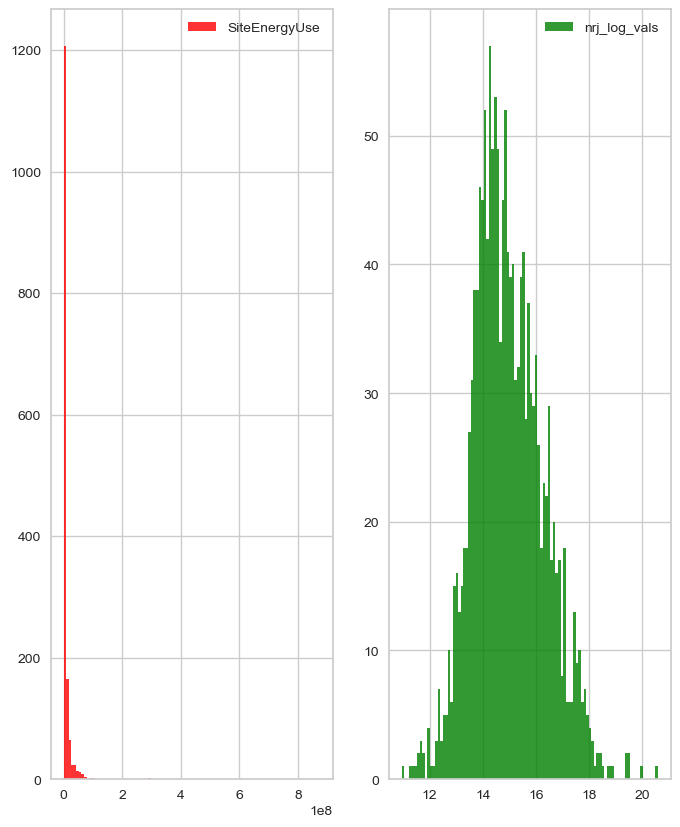

In [12]:
# Comparaison avec log
df1 = df.copy()
df1['nrj_log_vals'] = np.log(df1['SiteEnergyUse'])
plt.figure()
fig, ax = plt.subplots(1,2,figsize=(8,10))
df1['nrj_log_vals'].hist(bins=100, alpha=0.8, legend=True,ax=ax[1],color='green')
df1['SiteEnergyUse'].hist(bins=100, alpha=0.8,legend=True,ax=ax[0],color='red')
plt.show()


In [13]:
df_clean = df1[['YearBuilt','NumberofBuildings','SteamUse(kBtu)', 'NaturalGas(kBtu)',  'Autres', 'Education',
       'EntertainmentPublicAssembly', 'FoodSalesService', 'Healthcare',
       'LodgingResidential', 'Office', 'Other', 'Parking', 'ReligiousWorship',
       'Retail', 'TechnologyScience', 'WarehouseStorage','Outlier','SiteEnergyUse','nrj_log_vals']]

In [14]:
df_star = df1[['YearBuilt','NumberofBuildings','SteamUse(kBtu)', 'NaturalGas(kBtu)',  'Autres', 'Education',
       'EntertainmentPublicAssembly', 'FoodSalesService', 'Healthcare',
       'LodgingResidential', 'Office', 'Other', 'Parking', 'ReligiousWorship',
       'Retail', 'TechnologyScience', 'WarehouseStorage','ENERGYSTARScore','Outlier','SiteEnergyUse','nrj_log_vals']]

## Sélection de modèles

In [15]:
# Modèles sélectionnés:
dummy_reg = DummyRegressor()
lin_reg = LinearRegression()
ridge = Ridge(random_state=0)
lasso = Lasso(random_state=0)
dec_tree =  DecisionTreeRegressor(random_state=0)
svr = SVR()# Support Vector Regression
adaboost = AdaBoostRegressor(random_state=0)
bagging = BaggingRegressor(random_state=0)
gradientboosting = GradientBoostingRegressor(random_state=0)
forest = RandomForestRegressor()
xgboost = xgb.XGBRegressor(random_state=0)
Knregressor = KNeighborsRegressor()

# Evaluation des différents modèles de regression

Comparaison des méthodes
Pour la comparaison des methodes on vas baser sur :

Le RMSE (root mean squared error) fournit une indication sur la variance du modèle prédit. Plus précisément, il caractérise la taille des écarts entre observations et les mesures. Les valeurs du RMSE sont comprises entre [0;+∞[. Plus la valeur du critère RMSE est proche de zéro, meilleur est le modèle évalué en terme d’exactitude. Il faut donc minimiser la valeur du RMSE et choisir un modèle avec le RMSE le plus faible pour avoir un modèle qui se rapproche le plus des valeurs réelles.

MSE (Mean Square Error )Le carré moyen des erreurs : c’est la moyenne arithmétique des carrés des écarts entre prévisions du modèle et observations.C’est la valeur à minimiser dans le cadre d’une régression simple ou multiple. La méthode est fondée sur la nullité de la moyenne des résidus. Mais la moyenne de leurs carrés n'est généralement pas nulle. Cette moyenne n'est autre que la VARIANCE RÉSIDUELLE que l'on cherche à minimise

MAE (Mean Absolute Error)L’erreur absolue moyenne : moyenne arithmétique des valeurs absolues des écarts.

R2 correspond au coefficient de détermination et il s'agit du carré de la corrélation de Pearson entre les vraies valeurs et les valeurs prédites. Le coefficient de détermination nous indique donc à quel point les valeurs prédites sont corrélées aux vraies valeurs. Un modèle avec un R2 élevé prédit donc des valeurs prochent des données réelles et il est donc un bon modèle à priviléger pour notre problème. Il faut donc maximiser la valeur du R2.

In [16]:
# Création d'un dictionnaire de modèle
models = {'dummy_reg': DummyRegressor(),
    'lin_reg': LinearRegression(),
    'ridge' : Ridge(random_state=0),
    'lasso' : Lasso(random_state=0),
    'dec_tree':  DecisionTreeRegressor(random_state=0),
    'svr' : SVR(),
    'adaboost' :AdaBoostRegressor(random_state=0),
    'bagging ': BaggingRegressor(random_state=0),
    'gradientboosting': GradientBoostingRegressor(random_state=0),
    'forest' : RandomForestRegressor(),
    'xgboost' : xgb.XGBRegressor(random_state=0),
    'Knregressor' : KNeighborsRegressor()}

In [17]:
def evaluation_model(df,models,log=False,Outlier=True):
    if (log == True) & (Outlier == True):
        X = df.iloc[:,:-2].values
        y = df['nrj_log_vals'].values
        name = df.iloc[:,:-2].keys()
    elif (log == True) & (Outlier == False): 
        df = df.drop(df.loc[df['Outlier']==1].index)
        X = df.iloc[:,:-3].values
        y = df['nrj_log_vals'].values
        name = df.iloc[:,:-3].keys()
    elif (log == False) & (Outlier == False): 
        df = df.drop(df.loc[df['Outlier']==1].index)
        X = df.iloc[:,:-3].values
        y = df['SiteEnergyUse'].values
        name = df.iloc[:,:-3].keys()
    elif (log == False) & (Outlier == True): 
        X = df.iloc[:,:-2].values
        y = df['SiteEnergyUse'].values
        name = df.iloc[:,:-2].keys()
    else:  
        pass
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    
    df_modele =  pd.DataFrame(columns=['Modèle','Standardisation','Log','Outlier','MAE','MSE','RMSE','R2_train','Time_train','R2_predict','Time_predict'])

    for standardisers in [('StandardScaler', StandardScaler()),('MinMaxScaler', MinMaxScaler()),('RobustScaler', RobustScaler())]:
        
        scaler = standardisers[1]
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        
        results = []
        for i, model in enumerate(models):
            clf = models[model]                      
            clf.fit(X_train, y_train)
            # Calcul du temps d'entraînement
            start_time_train = time.time()
            r2_train = clf.score(X_train,y_train)
            time_end_train = time.time()
            # fin d'exécution

            # Calcul du temps de prédiction
            start_time_pred = time.time()
            y_pred = clf.predict(X_test)
            time_end_pred = time.time()
            # fin d'exécution

            r2_predict = r2_score(y_test, y_pred)
            MAE = mean_absolute_error(y_test, y_pred)
            MSE = mean_squared_error(y_test, y_pred)
            RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
            standardisation = standardisers[1]
            log_col = log
            outlier_col = Outlier
            # durée d'exécution de l'entraînement 
            time_execution_train = time_end_train - start_time_train

            # durée d'exécution de la prédiction
            time_execution_pred = time_end_pred - start_time_pred


            results.append([model,standardisation,log_col,outlier_col,round(MAE,3),round(MSE,3),round(RMSE,3),round(r2_train,3),time_execution_train,round(r2_predict,3),time_execution_pred])
        
            essai = pd.DataFrame(results, columns=['Modèle','Standardisation','Log','Outlier','MAE','MSE','RMSE','R2_train','Time_train','R2_predict','Time_predict'])
        df_modele = pd.concat([df_modele,essai])
        df_modele = df_modele.sort_values('R2_predict',ascending=False)
        
    vif_data = pd.DataFrame()
    vif_data["feature"] = name
    #calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(X_train, i)
                          for i in range(len(name))]

    print('VIF (facteur d\'inflation de la variance)')
    print(vif_data)
    return df_modele

In [18]:
def feature_importance(df,models,log=False,Outlier=True, coef=True):
    if (log == True) & (Outlier == True):
        X = df.iloc[:,:-2].values
        y = df['nrj_log_vals'].values
        name = df.iloc[:,:-2].keys()
    elif (log == True) & (Outlier == False): 
        df = df.drop(df.loc[df['Outlier']==1].index)
        X = df.iloc[:,:-3].values
        y = df['nrj_log_vals'].values
        name = df.iloc[:,:-3].keys()
    elif (log == False) & (Outlier == False): 
        df = df.drop(df.loc[df['Outlier']==1].index)
        X = df.iloc[:,:-3].values
        y = df['SiteEnergyUse'].values
        name = df.iloc[:,:-3].keys()
    elif (log == False) & (Outlier == True): 
        X = df.iloc[:,:-2].values
        y = df['SiteEnergyUse'].values
        name = df.iloc[:,:-2].keys()
    else:  
        pass
    
    
             
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    model = models
    if coef == True :
        importance_data = pd.DataFrame()
        importance_data['features'] = name
        importance_data['coef']= model.coef_
        # plot feature importance
        sns.barplot(data=importance_data, y='features',x='coef')
        plt.show()
    if coef == False :
        importance_data = pd.DataFrame()
        importance_data['features'] = name
        importance_data['coef']= model.feature_importances_
        # plot feature importance
        sns.barplot(data=importance_data, y='features',x='coef')
        plt.show()

In [19]:
standardisers_1 = [StandardScaler(),MinMaxScaler(),RobustScaler()]

In [20]:
def predic_plot(df,model,log=False,Outlier=True,standardisers=standardisers_1[0]):
    if (log == True) & (Outlier == True):
        X = df.iloc[:,:-2].values
        y = df['nrj_log_vals'].values
        name = df.iloc[:,:-2].keys()
        
    elif (log == True) & (Outlier == False): 
        
        df = df.drop(df.loc[df['Outlier']==1].index)
        X = df.iloc[:,:-3].values
        y = df['nrj_log_vals'].values
        name = df.iloc[:,:-3].keys()
    
    elif (log == False) & (Outlier == False): 
        df = df.drop(df.loc[df['Outlier']==1].index)
        X = df.iloc[:,:-3].values
        y = df['SiteEnergyUse'].values
        name = df.iloc[:,:-3].keys()
    
    else:  
        X = df.iloc[:,:-2].values
        y = df['SiteEnergyUse'].values
        name = df.iloc[:,:-2].keys()
       
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    
    scaler = standardisers
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
        
     
    label=['y_pred','y_test']
    
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    
    r2_train = model.score(X_train,y_train)
    r2_predict = r2_score(y_test, y_pred)
    MAE = mean_absolute_error(y_test, y_pred)
    MSE = mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    print('R² train :',r2_train)
    print('R² predict:',r2_predict)
    print('MAE :',MAE)
    print('MSE :',MSE)
    print('RMSE :',RMSE)
    
    
    
    plt.plot(model.predict(X_test),y_test,'o',label=label,alpha=0.5)
    min_tru=y_test.min()
    max_tru=y_test.max()
    plt.plot([min_tru, max_tru], [min_tru, max_tru], '--') 
    plt.title('Comparaison de Y_pred et Y_test')
    plt.xlabel("Y_pred")
    plt.ylabel("Y_test")
    plt.legend(label)
    plt.show()
    
    visualizer = ResidualsPlot(model,hist=True)

    visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
    visualizer.score(X_test, y_test)  # Evaluate the model on the test data
    visualizer.show()                 # Finalize and render the figure
    
    
    visualizer = prediction_error(model, X_train, y_train, X_test, y_test)
    
    N, train_score,val_score = learning_curve(model,X_train,y_train, cv=4,train_sizes=np.linspace(0.1, 1.0, 5))
    
    plt.figure(figsize=(12,8))
    plt.title('Validation Curve')
    plt.plot(N,train_score.mean(axis=1), label= 'train score')
    plt.plot(N,val_score.mean(axis=1), label = 'validation score')
    plt.legend()
    plt.show()

In [21]:
# Evaluation des modèles sans log et avec outliers
evaluation_model(df_clean, models,log=False,Outlier=True)

VIF (facteur d'inflation de la variance)
                        feature       VIF
0                     YearBuilt  1.122042
1             NumberofBuildings  1.250383
2                SteamUse(kBtu)  1.244772
3              NaturalGas(kBtu)  1.142903
4                        Autres  1.138080
5                     Education  1.145082
6   EntertainmentPublicAssembly  1.124983
7              FoodSalesService  1.151207
8                    Healthcare  1.347765
9            LodgingResidential  1.223053
10                       Office  2.140517
11                        Other  1.206840
12                      Parking  1.921515
13             ReligiousWorship  1.008908
14                       Retail  1.153047
15            TechnologyScience  1.109145
16             WarehouseStorage  1.029342
17                      Outlier  2.294685


,Modèle,Standardisation,Log,Outlier,MAE,MSE,RMSE,R2_train,Time_train,R2_predict,Time_predict
1,lin_reg,StandardScaler(),False,True,4.703351e+06,4.336188e+14,2.082352e+07,0.743,0.000000,0.849,0.000000
3,lasso,RobustScaler(),False,True,4.703381e+06,4.336381e+14,2.082398e+07,0.743,0.000000,0.849,0.000000
1,lin_reg,MinMaxScaler(),False,True,4.703351e+06,4.336188e+14,2.082352e+07,0.743,0.000000,0.849,0.000000
3,lasso,MinMaxScaler(),False,True,4.703382e+06,4.336394e+14,2.082401e+07,0.743,0.000000,0.849,0.000000
1,lin_reg,RobustScaler(),False,True,4.703351e+06,4.336188e+14,2.082352e+07,0.743,0.000000,0.849,0.000000
3,lasso,StandardScaler(),False,True,4.703352e+06,4.336195e+14,2.082353e+07,0.743,0.000000,0.849,0.000000
2,ridge,StandardScaler(),False,True,4.704750e+06,4.350503e+14,2.085786e+07,0.743,0.000000,0.848,0.000000
2,ridge,RobustScaler(),False,True,5.995136e+06,1.116839e+15,3.341914e+07,0.696,0.000000,0.610,0.000000
2,ridge,MinMaxScaler(),False,True,6.023814e+06,1.140701e+15,3.377426e+07,0.694,0.000000,0.602,0.000000
8,gradientboosting,MinMaxScaler(),False,True,6.494130e+06,2.198527e+15,4.688845e+07,0.969,0.001003,0.233,0.000000


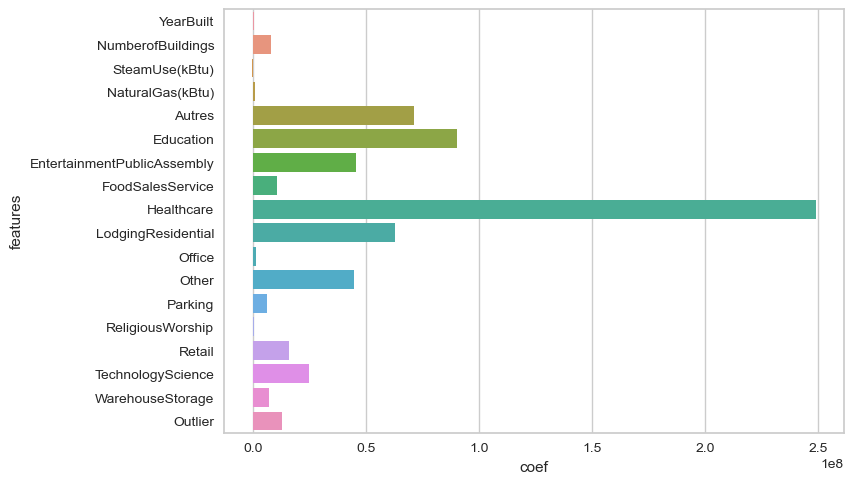

In [22]:
feature_importance(df_clean,models['lin_reg'],log=False,Outlier=True)

R² train : 0.7433433093150346
R² predict: 0.8487269291836915
MAE : 4703351.467241452
MSE : 433618809839764.7
RMSE : 20823515.78960106


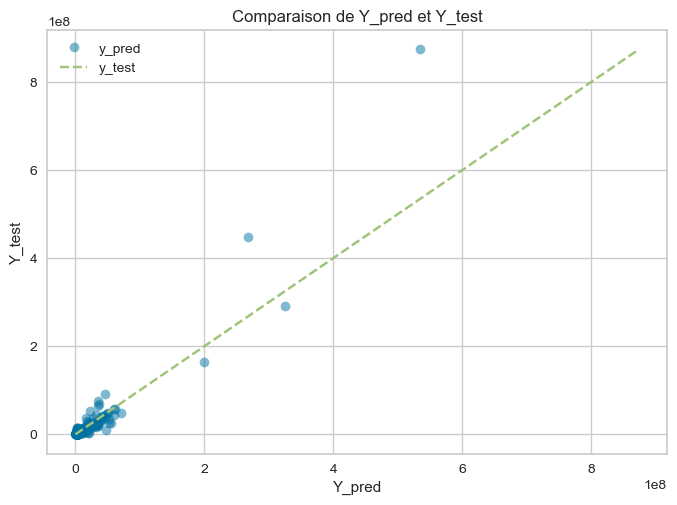

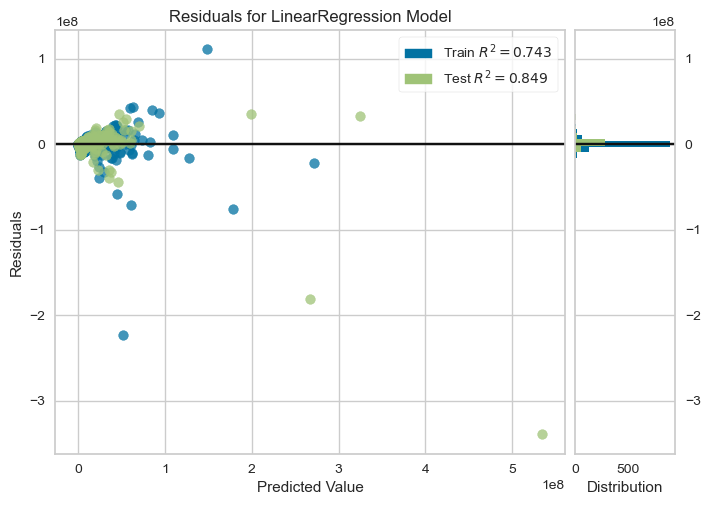

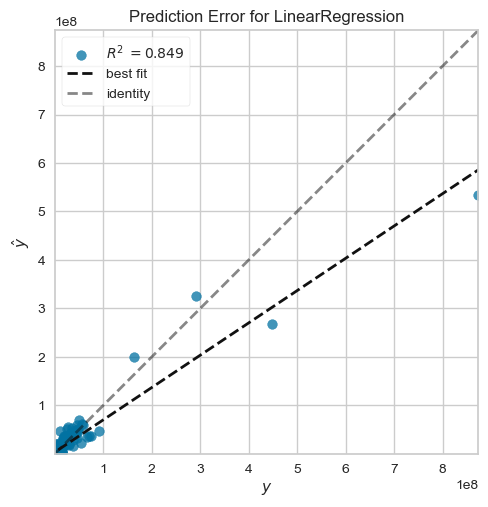

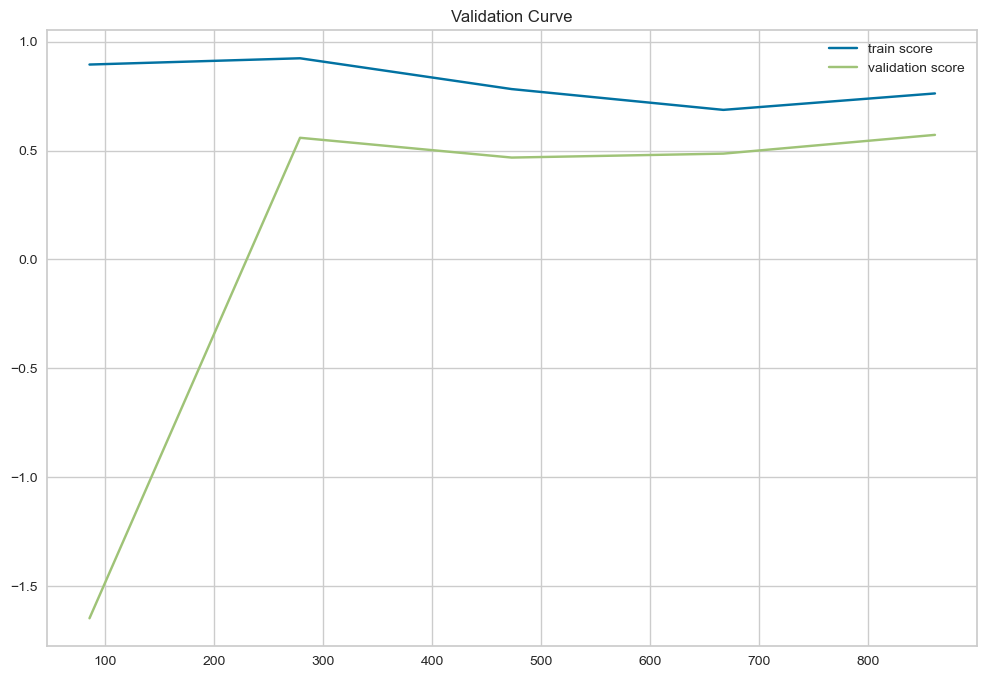

In [23]:
# Affichage du meilleur modèle
predic_plot(df_clean,models['lin_reg'],log=False,Outlier=True,standardisers=standardisers_1[0])

In [24]:
# Evaluation des modèles sans log et sans outliers
evaluation_model(df_clean, models,log=False,Outlier=False)

VIF (facteur d'inflation de la variance)
                        feature       VIF
0                     YearBuilt  1.150643
1             NumberofBuildings  1.055985
2                SteamUse(kBtu)  1.178102
3              NaturalGas(kBtu)  1.246549
4                        Autres  1.028989
5                     Education  1.011496
6   EntertainmentPublicAssembly  1.264206
7              FoodSalesService  1.040220
8                    Healthcare  1.009403
9            LodgingResidential  1.030244
10                       Office  1.638688
11                        Other  1.045421
12                      Parking  1.787590
13             ReligiousWorship  1.008743
14                       Retail  1.070557
15            TechnologyScience  1.028145
16             WarehouseStorage  1.033247


,Modèle,Standardisation,Log,Outlier,MAE,MSE,RMSE,R2_train,Time_train,R2_predict,Time_predict
9,forest,RobustScaler(),False,False,1409317.779,4.762125e+12,2182229.365,0.931,0.015625,0.651,0.015626
7,bagging,MinMaxScaler(),False,False,1435442.696,4.832893e+12,2198384.101,0.905,0.015626,0.646,0.000000
7,bagging,StandardScaler(),False,False,1439431.037,4.852820e+12,2202911.628,0.905,0.000000,0.645,0.000000
7,bagging,RobustScaler(),False,False,1442682.362,4.866892e+12,2206103.388,0.905,0.000000,0.644,0.000000
8,gradientboosting,StandardScaler(),False,False,1486115.322,4.892646e+12,2211932.565,0.766,0.000000,0.642,0.000000
8,gradientboosting,MinMaxScaler(),False,False,1486115.322,4.892646e+12,2211932.565,0.766,0.000000,0.642,0.000000
8,gradientboosting,RobustScaler(),False,False,1485720.440,4.892491e+12,2211897.646,0.766,0.015626,0.642,0.000000
9,forest,MinMaxScaler(),False,False,1424167.745,4.911941e+12,2216289.881,0.932,0.015626,0.640,0.015626
9,forest,StandardScaler(),False,False,1447546.036,5.027762e+12,2242267.140,0.930,0.015627,0.632,0.015625
10,xgboost,StandardScaler(),False,False,1502678.881,5.632175e+12,2373220.348,0.978,0.000000,0.588,0.000000


R² train : 0.904595656939823
R² predict: 0.6460987642624985
MAE : 1435442.6964088676
MSE : 4832892657515.201
RMSE : 2198384.1014516097


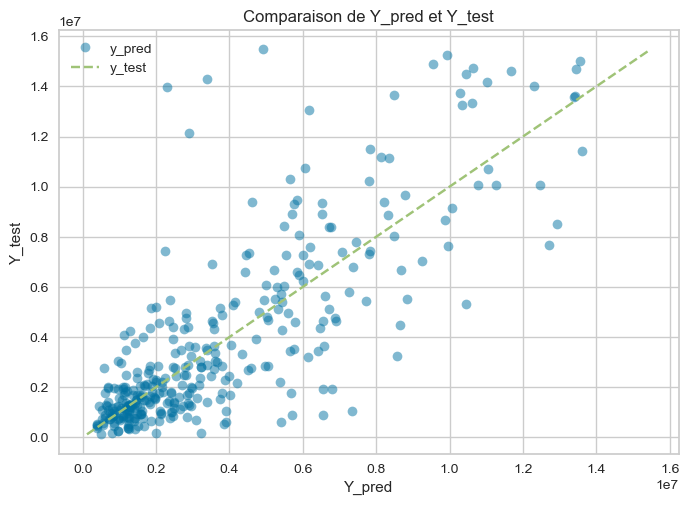

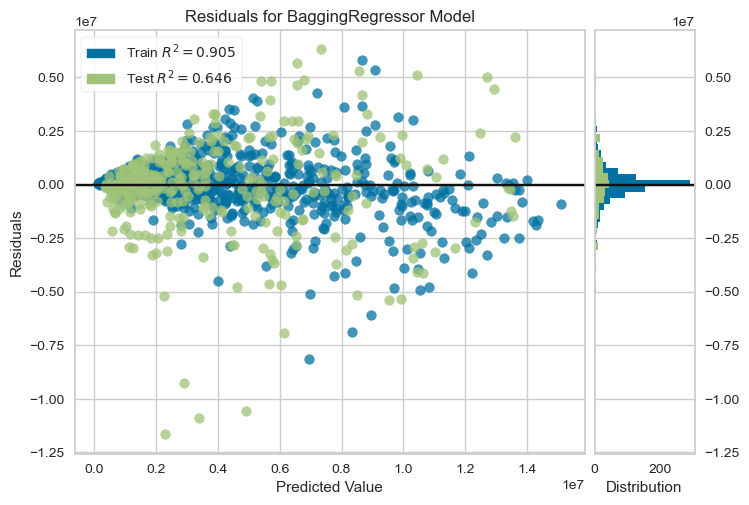

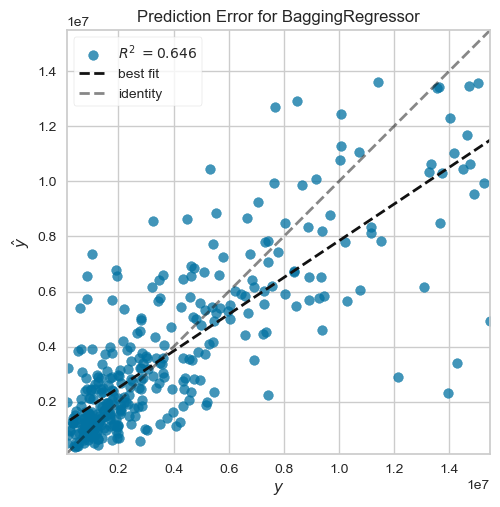

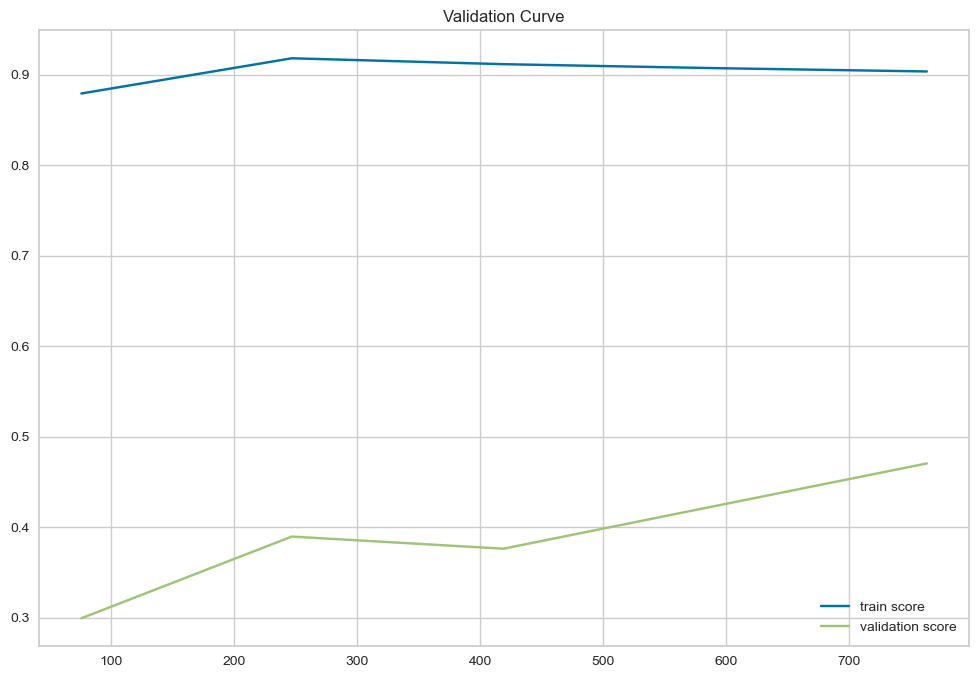

In [25]:
predic_plot(df_clean,models['bagging '],log=False,Outlier=False,standardisers=standardisers_1[1])

In [26]:
# Evaluation des modèles avec log et sans outliers
evaluation_model(df_clean, models,log=True,Outlier=False)

VIF (facteur d'inflation de la variance)
                        feature       VIF
0                     YearBuilt  1.150643
1             NumberofBuildings  1.055985
2                SteamUse(kBtu)  1.178102
3              NaturalGas(kBtu)  1.246549
4                        Autres  1.028989
5                     Education  1.011496
6   EntertainmentPublicAssembly  1.264206
7              FoodSalesService  1.040220
8                    Healthcare  1.009403
9            LodgingResidential  1.030244
10                       Office  1.638688
11                        Other  1.045421
12                      Parking  1.787590
13             ReligiousWorship  1.008743
14                       Retail  1.070557
15            TechnologyScience  1.028145
16             WarehouseStorage  1.033247


,Modèle,Standardisation,Log,Outlier,MAE,MSE,RMSE,R2_train,Time_train,R2_predict,Time_predict
5,svr,StandardScaler(),True,False,0.469,0.377,0.614,0.674,0.078137,0.621,0.031252
8,gradientboosting,RobustScaler(),True,False,0.477,0.379,0.615,0.717,0.000000,0.619,0.000000
8,gradientboosting,MinMaxScaler(),True,False,0.477,0.379,0.615,0.717,0.000000,0.619,0.000000
8,gradientboosting,StandardScaler(),True,False,0.478,0.380,0.616,0.717,0.000000,0.618,0.000000
9,forest,MinMaxScaler(),True,False,0.487,0.419,0.647,0.937,0.015626,0.579,0.000000
9,forest,StandardScaler(),True,False,0.486,0.421,0.648,0.940,0.015644,0.577,0.015626
9,forest,RobustScaler(),True,False,0.489,0.423,0.651,0.940,0.015626,0.574,0.000000
10,xgboost,StandardScaler(),True,False,0.499,0.427,0.654,0.955,0.000000,0.570,0.000000
10,xgboost,MinMaxScaler(),True,False,0.501,0.430,0.656,0.955,0.002090,0.568,0.001039
5,svr,MinMaxScaler(),True,False,0.502,0.431,0.657,0.572,0.062504,0.567,0.031252


R² train : 0.6741847178214604
R² predict: 0.6211571701028709
MAE : 0.46854347199421575
MSE : 0.3768021865615509
RMSE : 0.6138421511769544


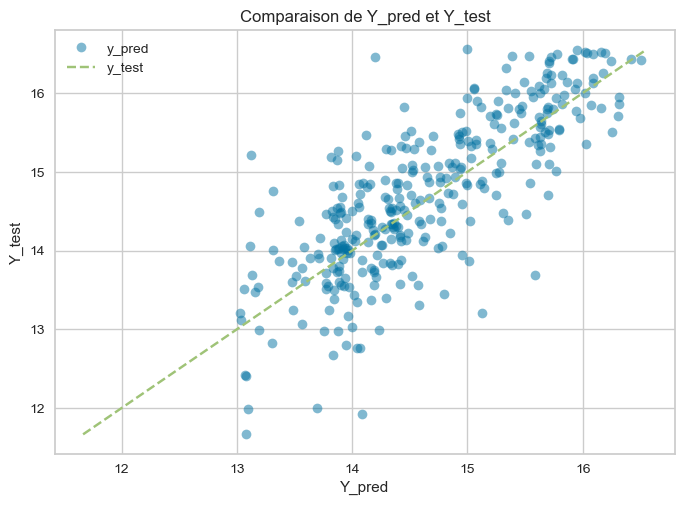

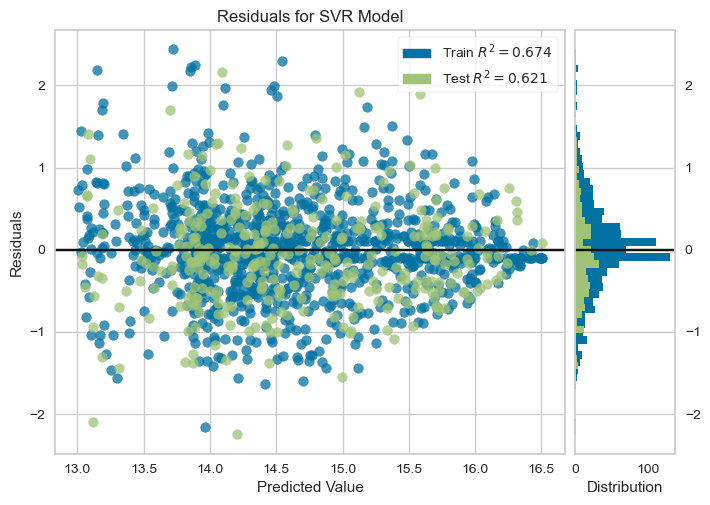

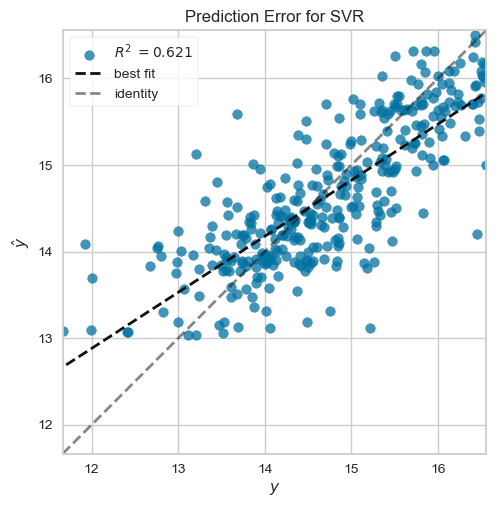

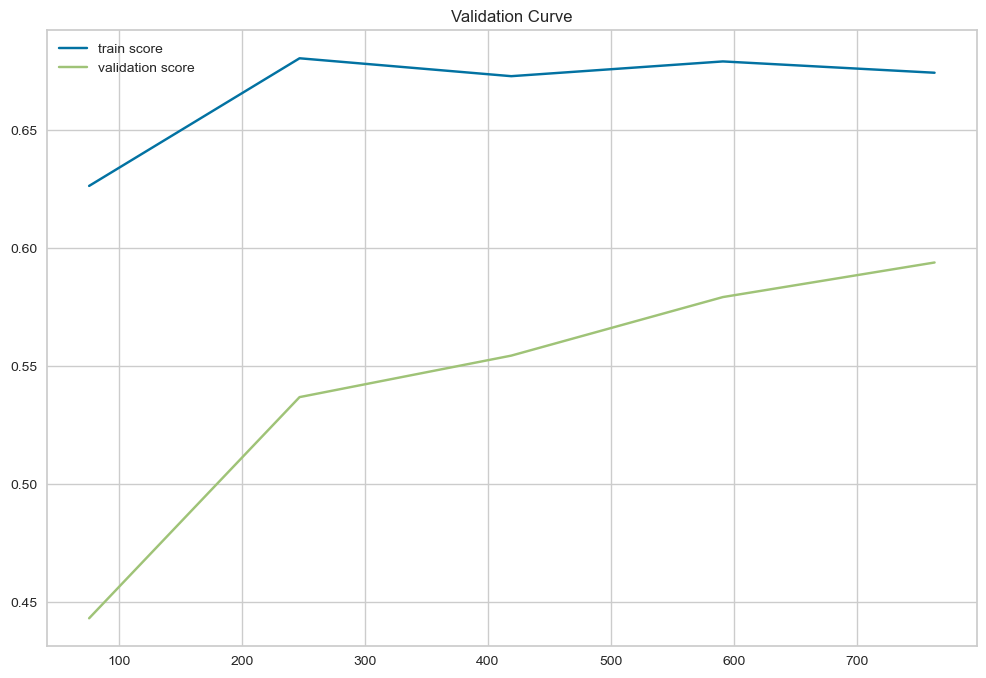

In [27]:
predic_plot(df_clean,models['svr'],log=True,Outlier=False,standardisers=standardisers_1[0])

In [28]:
# Evaluation des modèles avec log et outliers
evaluation_model(df_clean, models,log=True,Outlier=True)

VIF (facteur d'inflation de la variance)
                        feature       VIF
0                     YearBuilt  1.122042
1             NumberofBuildings  1.250383
2                SteamUse(kBtu)  1.244772
3              NaturalGas(kBtu)  1.142903
4                        Autres  1.138080
5                     Education  1.145082
6   EntertainmentPublicAssembly  1.124983
7              FoodSalesService  1.151207
8                    Healthcare  1.347765
9            LodgingResidential  1.223053
10                       Office  2.140517
11                        Other  1.206840
12                      Parking  1.921515
13             ReligiousWorship  1.008908
14                       Retail  1.153047
15            TechnologyScience  1.109145
16             WarehouseStorage  1.029342
17                      Outlier  2.294685


,Modèle,Standardisation,Log,Outlier,MAE,MSE,RMSE,R2_train,Time_train,R2_predict,Time_predict
9,forest,RobustScaler(),True,True,0.482,0.418,0.646,0.963,0.015626,0.782,0.015626
9,forest,MinMaxScaler(),True,True,0.489,0.427,0.653,0.962,0.015626,0.777,0.015626
9,forest,StandardScaler(),True,True,0.488,0.430,0.656,0.963,0.015626,0.775,0.000000
8,gradientboosting,StandardScaler(),True,True,0.508,0.442,0.665,0.816,0.000000,0.769,0.000000
8,gradientboosting,MinMaxScaler(),True,True,0.508,0.442,0.665,0.816,0.000000,0.769,0.000000
8,gradientboosting,RobustScaler(),True,True,0.508,0.442,0.665,0.816,0.000000,0.769,0.000000
10,xgboost,StandardScaler(),True,True,0.510,0.460,0.678,0.969,0.000000,0.760,0.000000
10,xgboost,MinMaxScaler(),True,True,0.510,0.459,0.678,0.969,0.000000,0.760,0.000000
10,xgboost,RobustScaler(),True,True,0.510,0.459,0.678,0.969,0.000000,0.760,0.000000
7,bagging,StandardScaler(),True,True,0.511,0.461,0.679,0.947,0.000000,0.759,0.000000


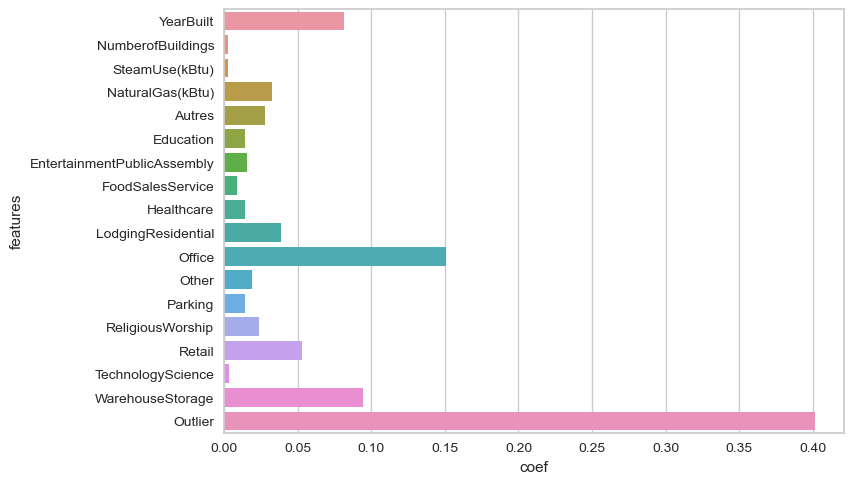

In [29]:
feature_importance(df_clean,models['forest'],log=True,Outlier=True,coef=False)

R² train : 0.9622004548014319
R² predict: 0.7826952911948459
MAE : 0.4791861260012558
MSE : 0.4159456027053161
RMSE : 0.6449384487726841


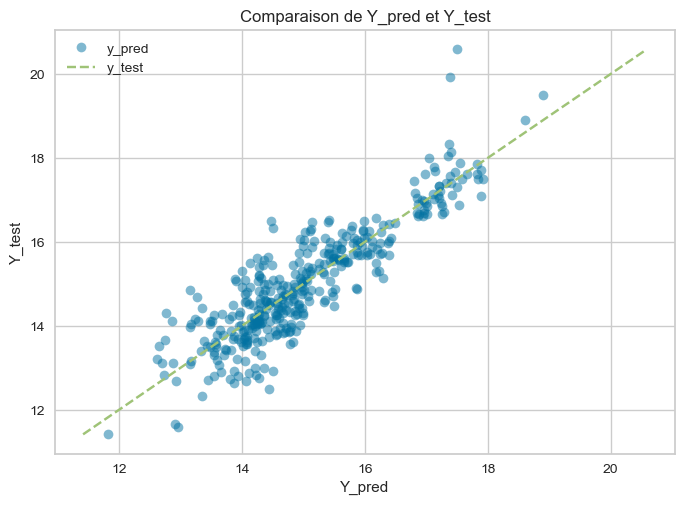

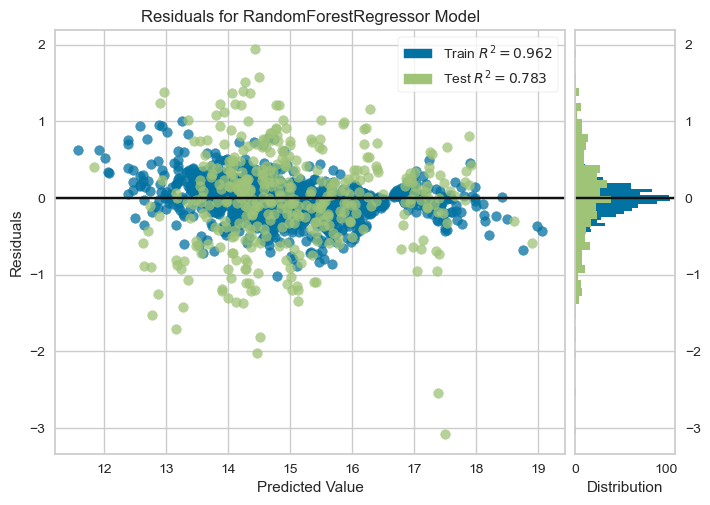

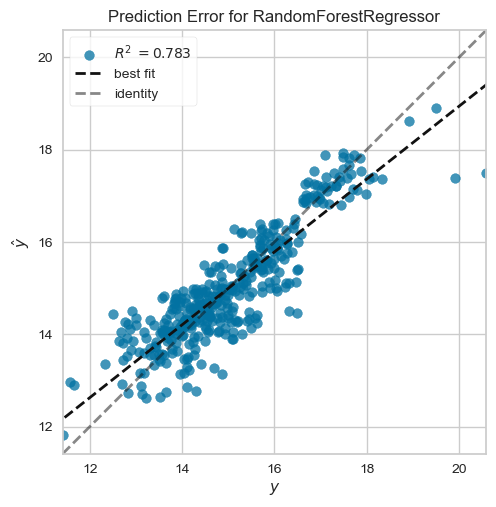

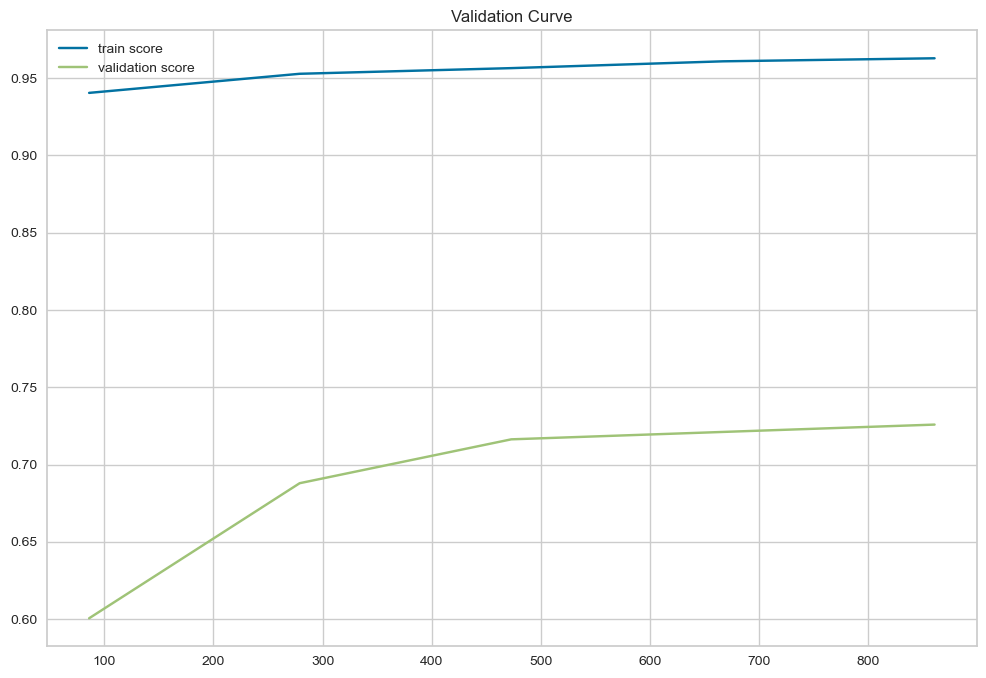

In [30]:
predic_plot(df_clean,models['forest'],log=True,Outlier=True,standardisers=standardisers_1[0])

La **regression linéaire** obtient le meilleur résultat pour ces premiers tests. 

# Modèle avec EnergieScore

In [31]:
# Evaluation des modèles sans log et avec outliers
evaluation_model(df_star, models,log=False,Outlier=True)

VIF (facteur d'inflation de la variance)
                        feature       VIF
0                     YearBuilt  1.124374
1             NumberofBuildings  1.250406
2                SteamUse(kBtu)  1.244772
3              NaturalGas(kBtu)  1.143950
4                        Autres  1.141118
5                     Education  1.146261
6   EntertainmentPublicAssembly  1.125435
7              FoodSalesService  1.151466
8                    Healthcare  1.353308
9            LodgingResidential  1.223478
10                       Office  2.201915
11                        Other  1.208193
12                      Parking  1.924629
13             ReligiousWorship  1.011615
14                       Retail  1.154504
15            TechnologyScience  1.109357
16             WarehouseStorage  1.030728
17              ENERGYSTARScore  1.075246
18                      Outlier  2.334496


,Modèle,Standardisation,Log,Outlier,MAE,MSE,RMSE,R2_train,Time_train,R2_predict,Time_predict
1,lin_reg,StandardScaler(),False,True,4.580288e+06,4.221905e+14,2.054728e+07,0.744,0.000000,0.853,0.000000
3,lasso,MinMaxScaler(),False,True,4.580322e+06,4.222110e+14,2.054777e+07,0.744,0.000000,0.853,0.000000
3,lasso,RobustScaler(),False,True,4.580319e+06,4.222096e+14,2.054774e+07,0.744,0.000000,0.853,0.000000
1,lin_reg,RobustScaler(),False,True,4.580288e+06,4.221905e+14,2.054728e+07,0.744,0.000000,0.853,0.000000
3,lasso,StandardScaler(),False,True,4.580289e+06,4.221912e+14,2.054729e+07,0.744,0.000000,0.853,0.000000
1,lin_reg,MinMaxScaler(),False,True,4.580288e+06,4.221905e+14,2.054728e+07,0.744,0.000000,0.853,0.000000
2,ridge,StandardScaler(),False,True,4.581911e+06,4.236487e+14,2.058273e+07,0.744,0.000000,0.852,0.000000
2,ridge,RobustScaler(),False,True,5.888168e+06,1.104447e+15,3.323322e+07,0.697,0.000000,0.615,0.000000
2,ridge,MinMaxScaler(),False,True,5.928315e+06,1.131299e+15,3.363479e+07,0.695,0.000000,0.605,0.000000
8,gradientboosting,MinMaxScaler(),False,True,6.452509e+06,2.207698e+15,4.698615e+07,0.971,0.000000,0.230,0.000000


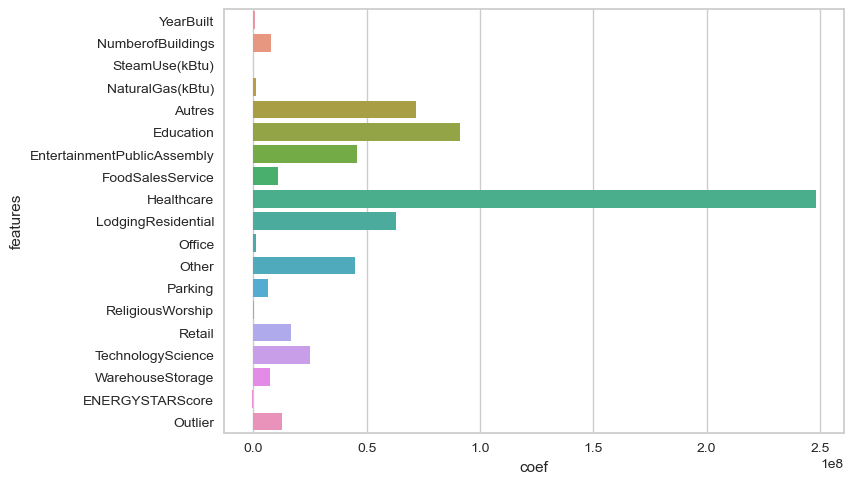

In [32]:
feature_importance(df_star,models['lin_reg'],log=False,Outlier=True,coef=True)

R² train : 0.7442095533655131
R² predict: 0.8527138254613855
MAE : 4580287.869855431
MSE : 422190515236109.94
RMSE : 20547275.129226014


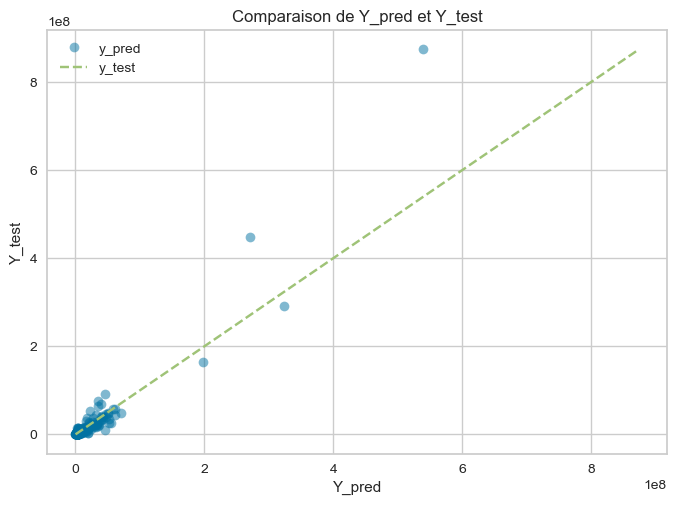

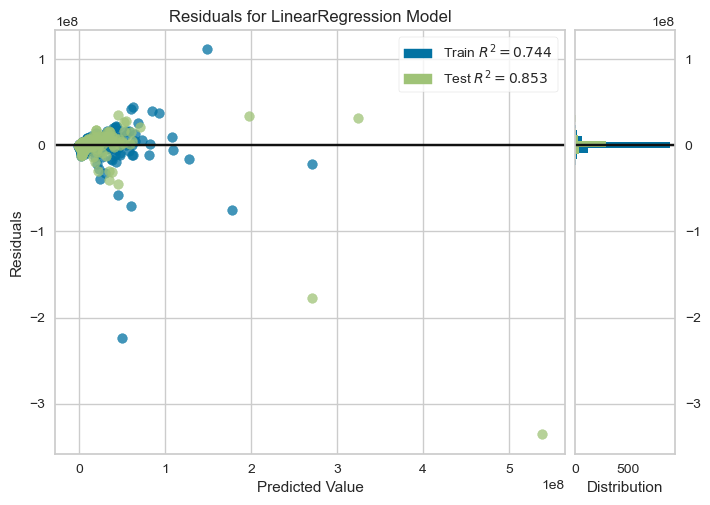

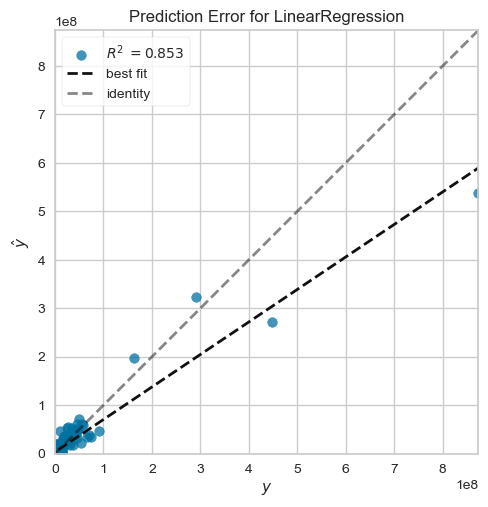

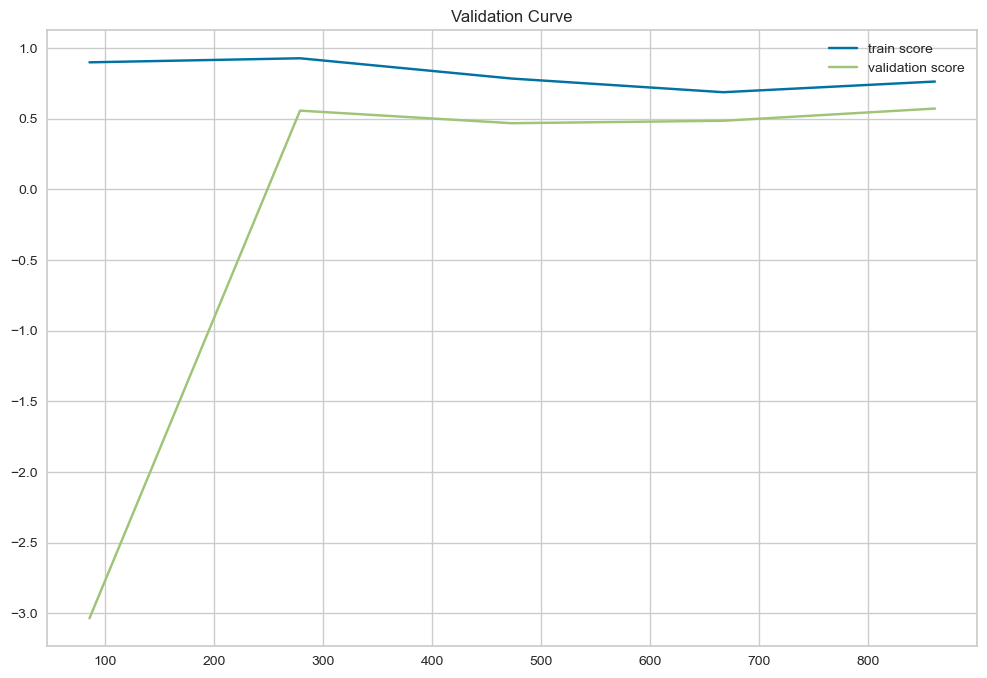

In [33]:
# Affichage du meilleur modèle
predic_plot(df_star,models['lin_reg'],log=False,Outlier=True,standardisers=standardisers_1[0])

In [34]:
# Evaluation des modèles sans log et sans outliers
evaluation_model(df_star, models,log=False,Outlier=False)

VIF (facteur d'inflation de la variance)
                        feature       VIF
0                     YearBuilt  1.156720
1             NumberofBuildings  1.056277
2                SteamUse(kBtu)  1.178213
3              NaturalGas(kBtu)  1.249512
4                        Autres  1.029540
5                     Education  1.025051
6   EntertainmentPublicAssembly  1.264275
7              FoodSalesService  1.042593
8                    Healthcare  1.010250
9            LodgingResidential  1.030582
10                       Office  1.693129
11                        Other  1.045575
12                      Parking  1.788327
13             ReligiousWorship  1.009194
14                       Retail  1.070776
15            TechnologyScience  1.029387
16             WarehouseStorage  1.033247
17              ENERGYSTARScore  1.069324


,Modèle,Standardisation,Log,Outlier,MAE,MSE,RMSE,R2_train,Time_train,R2_predict,Time_predict
9,forest,StandardScaler(),False,False,1260746.566,3.969848e+12,1992447.727,0.943,0.021312,0.709,0.010026
9,forest,RobustScaler(),False,False,1254843.438,3.993504e+12,1998375.245,0.940,0.031250,0.708,0.000000
9,forest,MinMaxScaler(),False,False,1259141.273,4.024756e+12,2006179.399,0.945,0.015626,0.705,0.000000
8,gradientboosting,MinMaxScaler(),False,False,1362822.783,4.044734e+12,2011152.471,0.812,0.000000,0.704,0.000000
8,gradientboosting,StandardScaler(),False,False,1362205.224,4.044579e+12,2011113.909,0.812,0.001029,0.704,0.000000
8,gradientboosting,RobustScaler(),False,False,1362822.783,4.044734e+12,2011152.471,0.812,0.015626,0.704,0.000000
7,bagging,RobustScaler(),False,False,1288528.878,4.174020e+12,2043041.782,0.924,0.000000,0.694,0.000000
7,bagging,MinMaxScaler(),False,False,1293102.832,4.181822e+12,2044950.460,0.924,0.008996,0.694,0.001021
7,bagging,StandardScaler(),False,False,1296204.025,4.190708e+12,2047121.935,0.924,0.003007,0.693,0.000884
10,xgboost,RobustScaler(),False,False,1334484.306,4.407028e+12,2099292.266,0.990,0.015655,0.677,0.000000


R² train : 0.8122314232022697
R² predict: 0.7038250873249597
MAE : 1362205.2243056498
MSE : 4044579154476.6
RMSE : 2011113.908876521


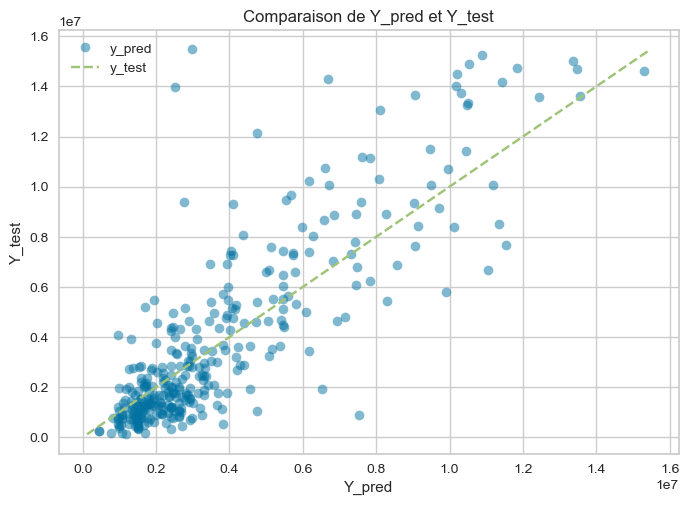

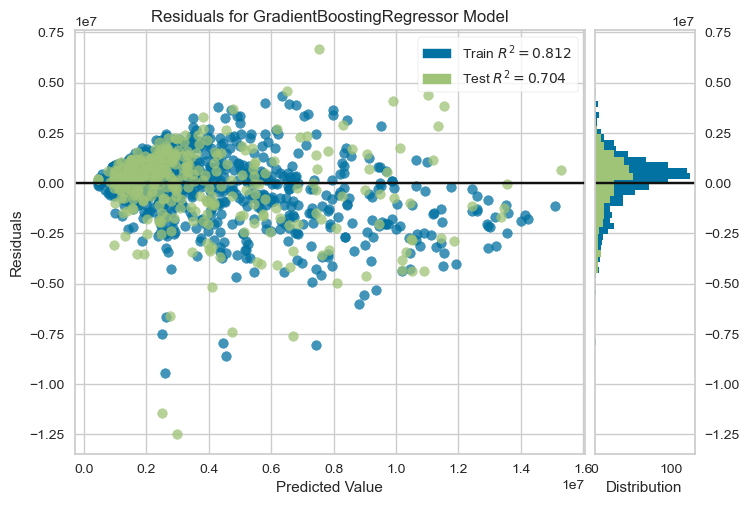

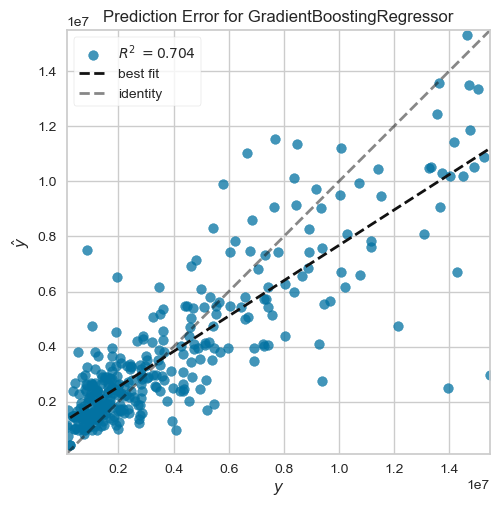

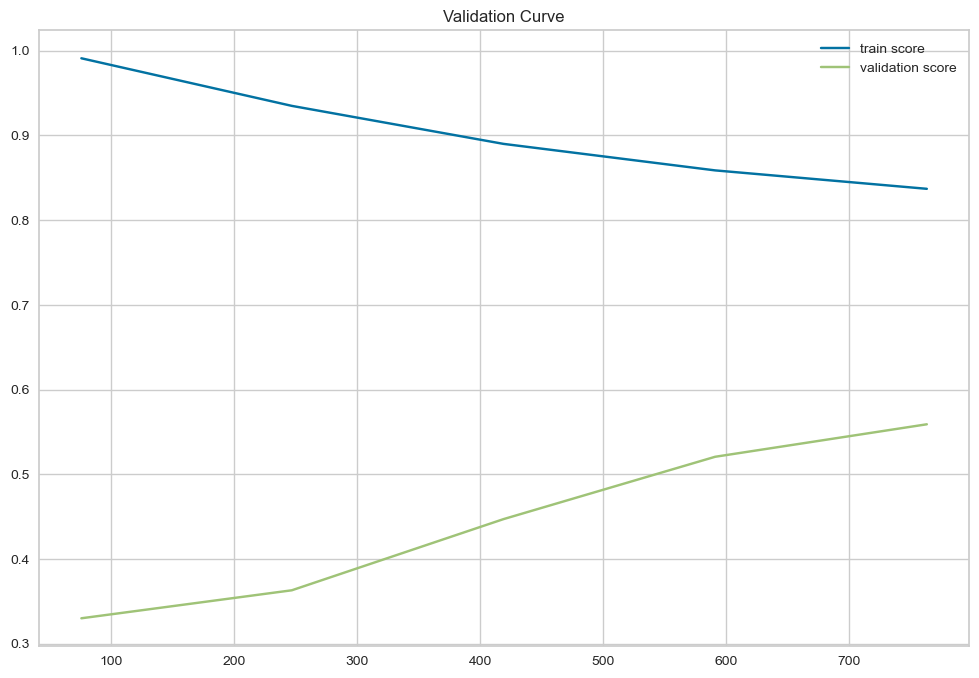

In [35]:
predic_plot(df_star,models['gradientboosting'],log=False,Outlier=False,standardisers=standardisers_1[0])

In [36]:
# Evaluation des modèles avec log et sans outliers
evaluation_model(df_star, models,log=True,Outlier=False)

VIF (facteur d'inflation de la variance)
                        feature       VIF
0                     YearBuilt  1.156720
1             NumberofBuildings  1.056277
2                SteamUse(kBtu)  1.178213
3              NaturalGas(kBtu)  1.249512
4                        Autres  1.029540
5                     Education  1.025051
6   EntertainmentPublicAssembly  1.264275
7              FoodSalesService  1.042593
8                    Healthcare  1.010250
9            LodgingResidential  1.030582
10                       Office  1.693129
11                        Other  1.045575
12                      Parking  1.788327
13             ReligiousWorship  1.009194
14                       Retail  1.070776
15            TechnologyScience  1.029387
16             WarehouseStorage  1.033247
17              ENERGYSTARScore  1.069324


,Modèle,Standardisation,Log,Outlier,MAE,MSE,RMSE,R2_train,Time_train,R2_predict,Time_predict
5,svr,StandardScaler(),True,False,0.405,0.292,0.541,0.758,0.078045,0.706,0.031252
8,gradientboosting,RobustScaler(),True,False,0.445,0.328,0.573,0.776,0.015626,0.670,0.000000
8,gradientboosting,StandardScaler(),True,False,0.446,0.328,0.573,0.776,0.000000,0.670,0.000000
8,gradientboosting,MinMaxScaler(),True,False,0.445,0.328,0.573,0.776,0.000000,0.670,0.000000
10,xgboost,StandardScaler(),True,False,0.430,0.344,0.587,0.980,0.000000,0.654,0.000000
10,xgboost,MinMaxScaler(),True,False,0.430,0.344,0.587,0.980,0.002008,0.654,0.001017
10,xgboost,RobustScaler(),True,False,0.431,0.344,0.587,0.980,0.015658,0.654,0.000000
9,forest,RobustScaler(),True,False,0.436,0.350,0.591,0.950,0.015613,0.648,0.000000
9,forest,StandardScaler(),True,False,0.443,0.355,0.596,0.948,0.015626,0.643,0.000000
9,forest,MinMaxScaler(),True,False,0.447,0.364,0.603,0.950,0.015626,0.634,0.000000


R² train : 0.7575501203290003
R² predict: 0.7061578216698596
MAE : 0.4049626361457063
MSE : 0.2922593924474458
RMSE : 0.5406102037951612


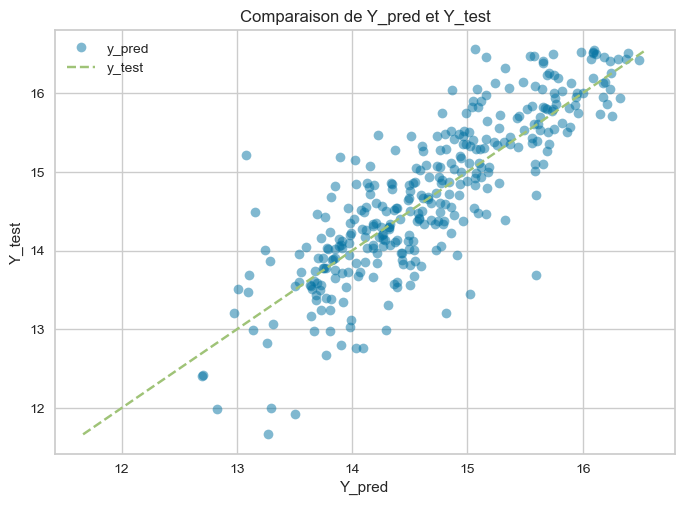

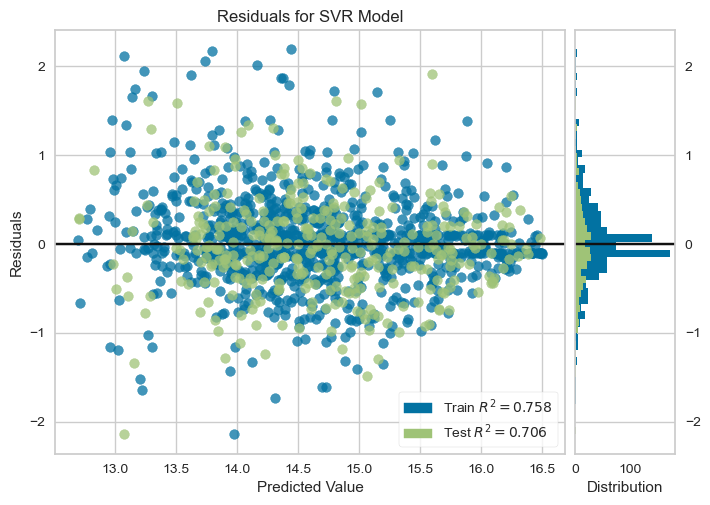

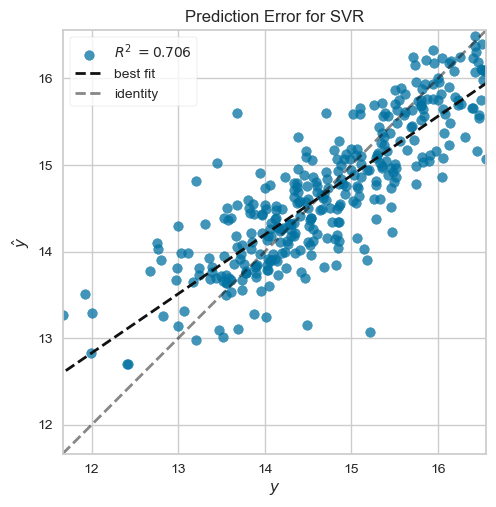

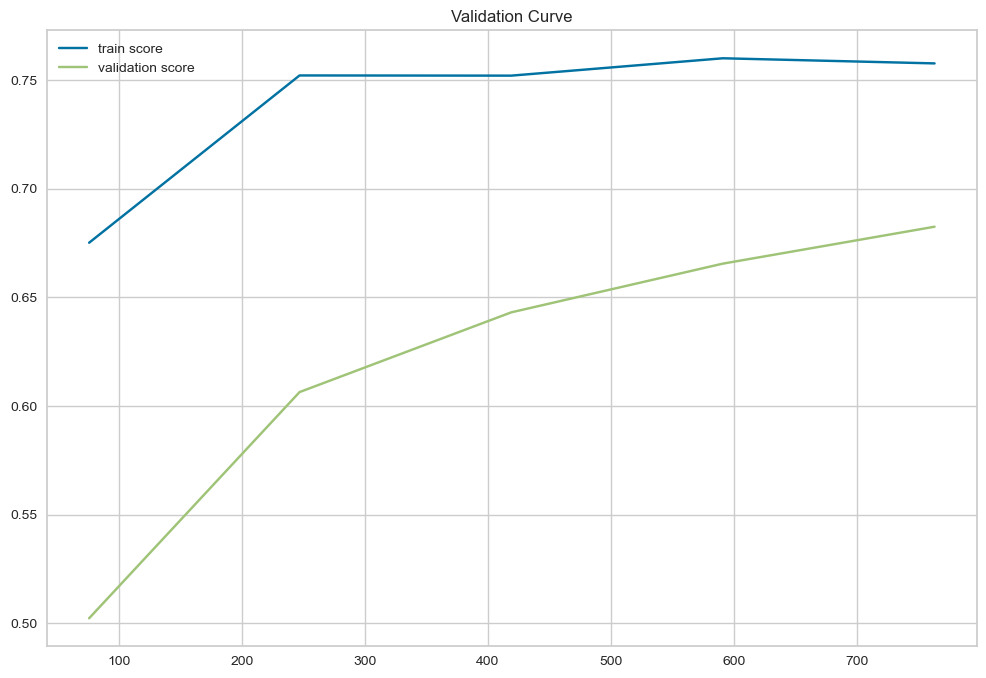

In [37]:
predic_plot(df_star,models['svr'],log=True,Outlier=False,standardisers=standardisers_1[0])

In [38]:
# Evaluation des modèles avec log et outliers
evaluation_model(df_star, models,log=True,Outlier=True)

VIF (facteur d'inflation de la variance)
                        feature       VIF
0                     YearBuilt  1.124374
1             NumberofBuildings  1.250406
2                SteamUse(kBtu)  1.244772
3              NaturalGas(kBtu)  1.143950
4                        Autres  1.141118
5                     Education  1.146261
6   EntertainmentPublicAssembly  1.125435
7              FoodSalesService  1.151466
8                    Healthcare  1.353308
9            LodgingResidential  1.223478
10                       Office  2.201915
11                        Other  1.208193
12                      Parking  1.924629
13             ReligiousWorship  1.011615
14                       Retail  1.154504
15            TechnologyScience  1.109357
16             WarehouseStorage  1.030728
17              ENERGYSTARScore  1.075246
18                      Outlier  2.334496


,Modèle,Standardisation,Log,Outlier,MAE,MSE,RMSE,R2_train,Time_train,R2_predict,Time_predict
9,forest,RobustScaler(),True,True,0.431,0.361,0.601,0.968,0.015626,0.812,0.015626
9,forest,StandardScaler(),True,True,0.435,0.362,0.601,0.969,0.015626,0.811,0.015626
9,forest,MinMaxScaler(),True,True,0.434,0.362,0.601,0.968,0.031248,0.811,0.000000
10,xgboost,RobustScaler(),True,True,0.439,0.373,0.611,0.984,0.015654,0.805,0.000000
10,xgboost,MinMaxScaler(),True,True,0.440,0.373,0.611,0.984,0.000000,0.805,0.000000
10,xgboost,StandardScaler(),True,True,0.440,0.373,0.611,0.984,0.015662,0.805,0.000000
8,gradientboosting,MinMaxScaler(),True,True,0.456,0.376,0.613,0.849,0.000000,0.804,0.000000
8,gradientboosting,StandardScaler(),True,True,0.457,0.376,0.614,0.849,0.000000,0.803,0.000000
8,gradientboosting,RobustScaler(),True,True,0.457,0.376,0.614,0.849,0.000000,0.803,0.000000
7,bagging,StandardScaler(),True,True,0.453,0.400,0.632,0.956,0.000000,0.791,0.000000


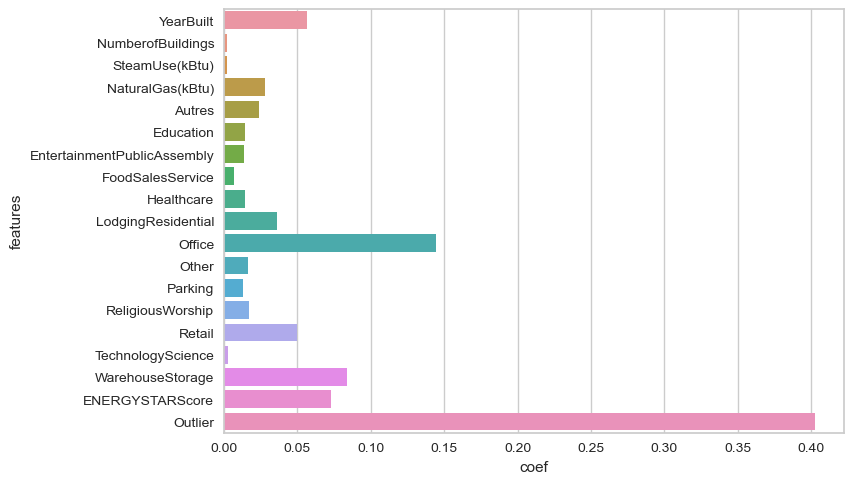

In [47]:
feature_importance(df_star,models['forest'],log=True,Outlier=True,coef=False)

R² train : 0.9695493803792965
R² predict: 0.8125999820802161
MAE : 0.4306544739130358
MSE : 0.3587046678796255
RMSE : 0.598919583817081


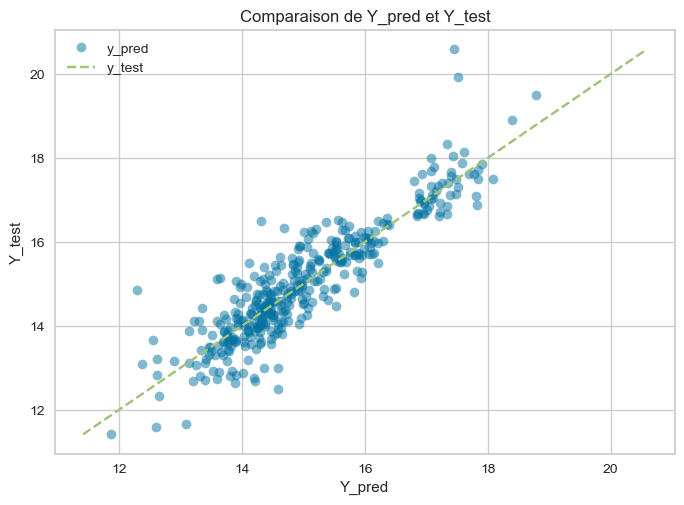

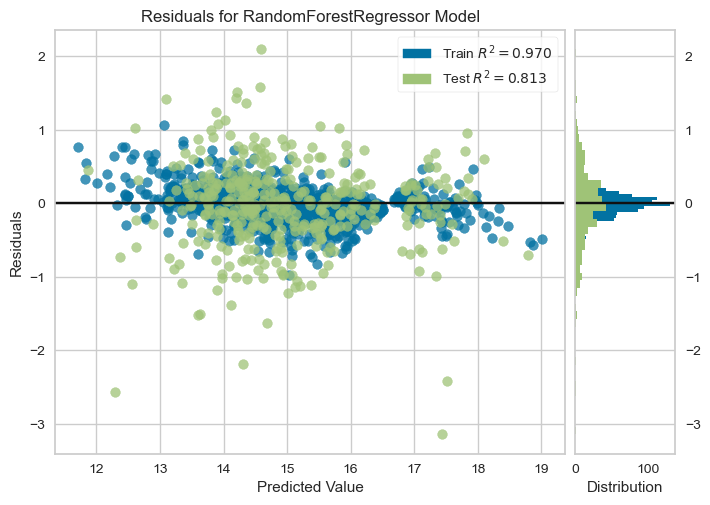

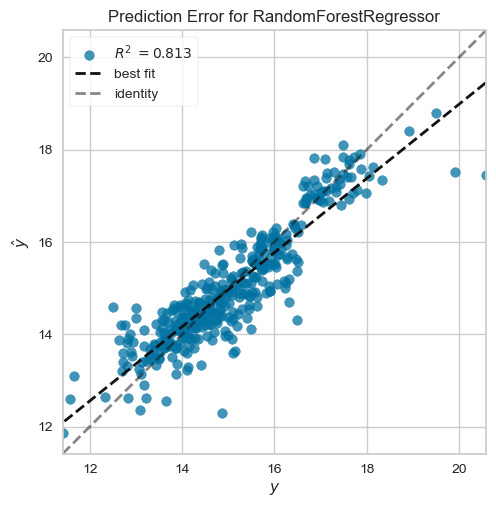

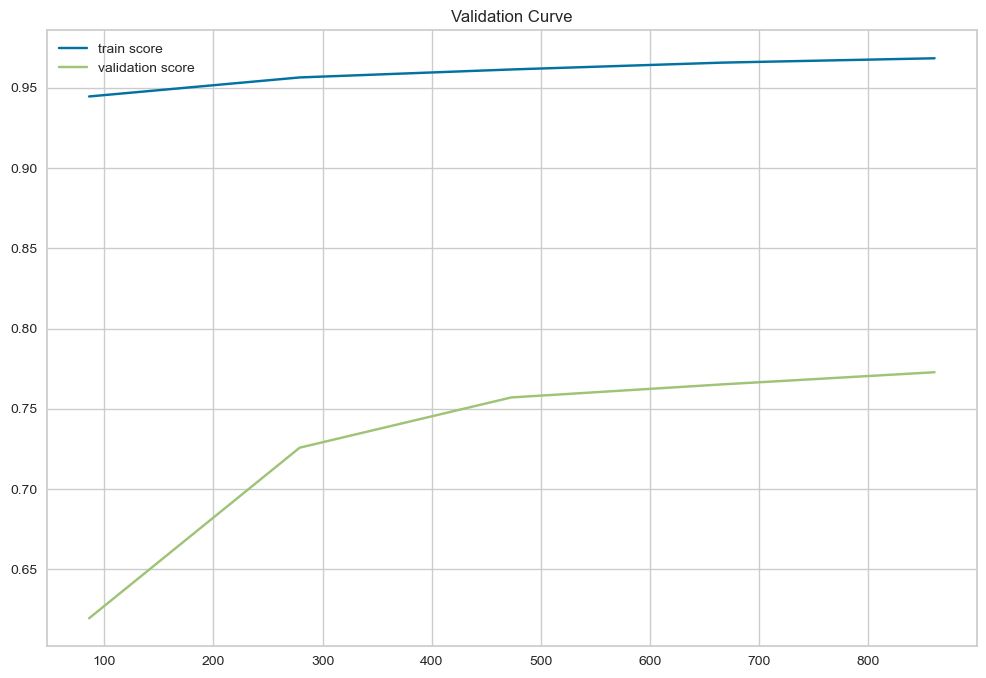

In [40]:
predic_plot(df_star,models['forest'],log=True,Outlier=True,standardisers=standardisers_1[0])

# Optimisation des paramètres

In [41]:
n_estimators = [5,20,50,100] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points

dico_models2 = {'n_estimators': n_estimators,

'max_features': max_features,

'max_depth': max_depth,

'min_samples_split': min_samples_split,

'min_samples_leaf': min_samples_leaf,

'bootstrap': bootstrap}



In [42]:
def optimize_model(df,models,log=False,Outlier=True,standardisers=StandardScaler(),dico_search=dico_models2,coef=True):
    if (log == True) & (Outlier == True):
        X = df.iloc[:,:-2].values
        y = df['nrj_log_vals'].values
        name = df.iloc[:,:-2].keys()
    elif (log == True) & (Outlier == False): 
        df = df.drop(df.loc[df['Outlier']==1].index)
        X = df.iloc[:,:-3].values
        y = df['nrj_log_vals'].values
        name = df.iloc[:,:-3].keys()
    elif (log == False) & (Outlier == False): 
        df = df.drop(df.loc[df['Outlier']==1].index)
        X = df.iloc[:,:-3].values
        y = df['SiteEnergyUse'].values
        name = df.iloc[:,:-3].keys()
    elif (log == False) & (Outlier == True): 
        X = df.iloc[:,:-2].values
        y = df['SiteEnergyUse'].values
        name = df.iloc[:,:-2].keys()
    else:  
        pass
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    
    scaler = standardisers
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
       
        
        
    search_grid= dico_search
    search=GridSearchCV(estimator=models,param_grid=search_grid,n_jobs=1,cv=2,verbose=1)
    search_result = search.fit(X_train,y_train)
    
    print('Best Params: ', search_result.best_params_)
    print('Best',search_result.best_estimator_)
    
    models = search_result.best_estimator_
    models.fit(X_train,y_train)
    y_pred = models.predict(X_test)
    
    r2_train = models.score(X_train,y_train)
    r2_predict = r2_score(y_test, y_pred)
    MAE = mean_absolute_error(y_test, y_pred)
    MSE = mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    print('R² train :',r2_train)
    print('R² predict:',r2_predict)
    print('MAE :',MAE)
    print('MSE :',MSE)
    print('RMSE :',RMSE)
    label=['y_pred','y_test']
    plt.plot(models.predict(X_test),y_test,'o',label=label,alpha=0.5)
    min_tru=y_test.min()
    max_tru=y_test.max()
    plt.plot([min_tru, max_tru], [min_tru, max_tru], '--') 
    plt.title('Comparaison de Y_pred et Y_test')
    plt.xlabel("Y_pred")
    plt.ylabel("Y_test")
    plt.legend(label)
    plt.show()
    
    visualizer = ResidualsPlot(models,hist=True)

    visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
    visualizer.score(X_test, y_test)  # Evaluate the model on the test data
    visualizer.show()                 # Finalize and render the figure
    
    
    visualizer = prediction_error(models, X_train, y_train, X_test, y_test)
    
    N, train_score,val_score = learning_curve(models,X_train,y_train, cv=4,train_sizes=np.linspace(0.1, 1.0, 5))
    
    plt.figure(figsize=(12,8))
    plt.title('Validation Curve')
    plt.plot(N,train_score.mean(axis=1), label= 'train score')
    plt.plot(N,val_score.mean(axis=1), label = 'validation score')
    plt.legend()
    plt.show()
    
    model = models
    if coef == True :
        importance_data = pd.DataFrame()
        importance_data['features'] = name
        importance_data['coef']= model.coef_
        # plot feature importance
        sns.barplot(data=importance_data, y='features',x='coef')
        plt.show()
    elif coef == False :
        model.fit(X,y)
        importance_data = pd.DataFrame()
        importance_data['features'] = name
        importance_data['coef']= model.feature_importances_
        # plot feature importance
        sns.barplot(data=importance_data, y='features',x='coef')
        plt.show()

# Optimisation du modèle

Fitting 2 folds for each of 1728 candidates, totalling 3456 fits
Best Params:  {'bootstrap': True, 'max_depth': 110, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best RandomForestRegressor(max_depth=110, max_features='sqrt')
R² train : 0.968960044711235
R² predict: 0.8158790043580013
MAE : 0.4333227818008621
MSE : 0.3524282512059287
RMSE : 0.5936566778921372


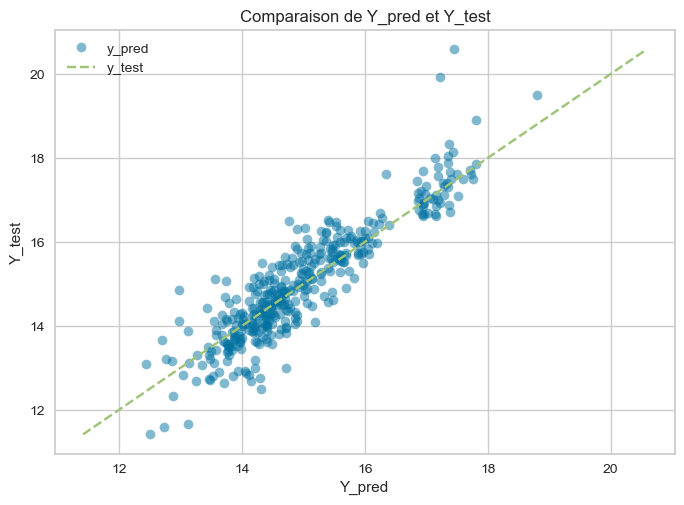

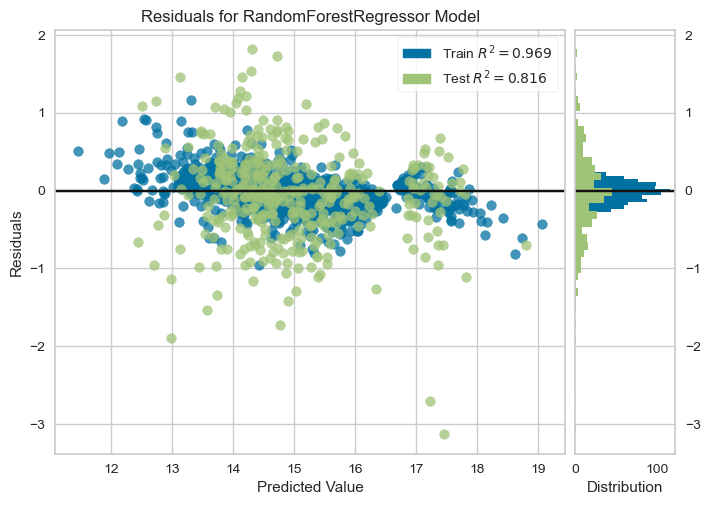

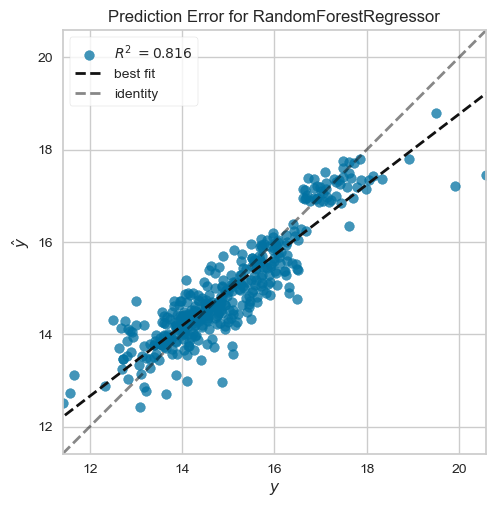

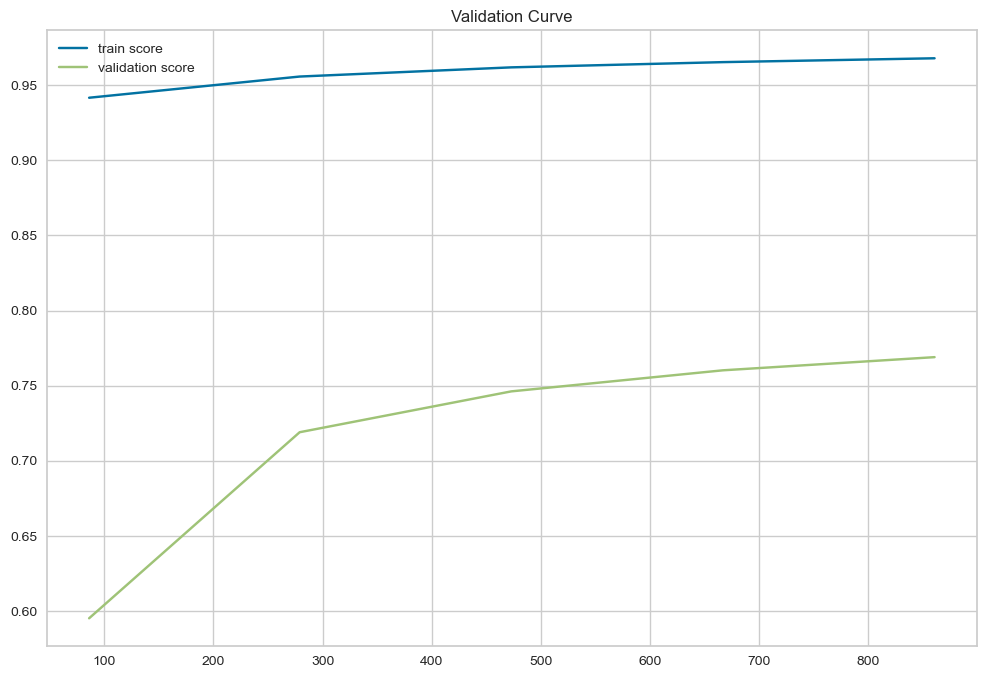

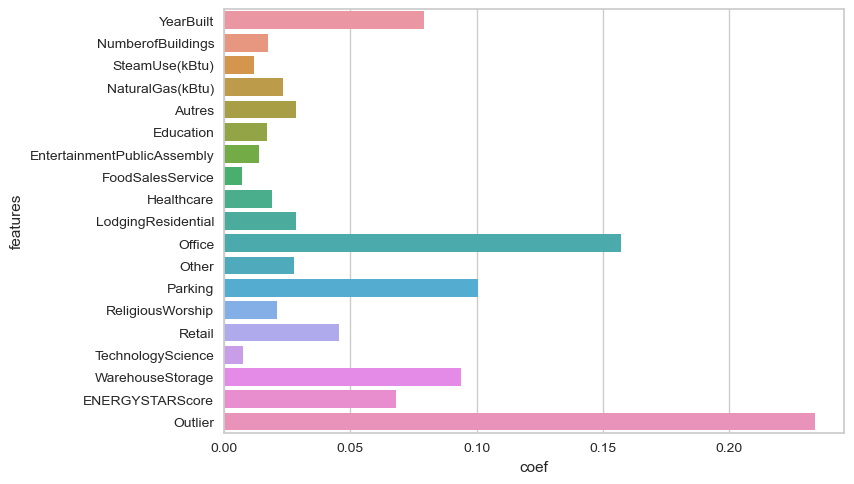

In [43]:
optimize_model(df_star,models['forest'],log=True,Outlier=True,standardisers=StandardScaler(),dico_search=dico_models2,coef=False)

Malgré l'optimisation des paramètres, le meilleur modèle reste la regression linéaire.